#### Setup

In [91]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [62]:
import torch
import torchaudio
import torch.nn as nn
import librosa
import librosa.display
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary

In [63]:
import torch
import torchaudio
import torch.nn as nn
import librosa
import librosa.display
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary

## Feature Engineering
Before building any sort of predictive models, we not only need data - but we need a usable representation. Enter feature engineering. 

An audio file can be represented as a time series with the dependent axis being
the amplitude of the audio waveform. The waveform of the sound file is all the information we have with which to create features to train our model. However, the shape of a waveform does not carry enough discriminating information, so we need to transform the waveform into a more useable form, pun intended. <br> 

Sometimes our input dataset _does_ have enough information to train a model to give accurate results - but even then input data should be scrutinized and transformed - this allows us to pick the best model for our features, which is usually much better and different than a model that works on our raw input data.  Proper feature engineering carries advantages not limited to 

 - **More accurate, generalizable models**
 - **Insight into model's decision-making behaviour**
 - **Flexibility in choice of models**
 - **Faster training** 
 


In [64]:
sample_rate = 8000

# Mel Spectrograms are not directly used as a feature in this model
# Mel Spectrograms are used in calculating MFCCs, which are a higher-level representation of pitch transition
# MFCCs work better - left the mel spectrogram function here in case anyone wants to experiment
def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 512,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
  
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms 
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)

    return melspectrogram


def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 128,
    fft = 512,
    winlen = 512,
    window='hamming',
    hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames 
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    
    # return all features from list of waveforms
    return features

def get_waveforms(file):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=6, offset=0.5, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*6,)))
    waveform_homo[:len(waveform)] = waveform
    
    # return a single file's waveform                                      
    return waveform_homo

# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict ={
    '0':'belly_pain',
    '1':'burping',
    '2':'discomfort',
    '3':'hungry',
    '4':'tired',
}


## Load Data and Extract Features


We process each file in the dataset and extract its features.

We return the waveforms and the labels (from the file names of the Infant Cry audio samples). We return the raw waveforms because we're going to do some extra processing.

In [65]:
# path to data for glob
data_path = 'D:\InfantCryClassifier\dataset\*.wav'

def load_data():
    # features and labels
    emotions = []
    # raw waveforms to augment later
    waveforms = []
    # extra labels
    genders = []
    # progress counter
    file_count = 0
    for file in glob.glob(data_path):
        # get file name with labels
        file_name = os.path.basename(file)
        
        # get emotion label from the sample's file
        emotion = ((file_name.split("-")[9]).split(".")[0])
        

        #  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing
        if emotion == 'bp': emotion = 0 # surprise is now at 0 index; other emotion indeces unchanged

        elif emotion == 'bu': emotion = 1

        elif emotion == 'dc': emotion = 2

        elif emotion == 'hu': emotion = 3

        elif emotion == 'ti': emotion = 4

        elif emotion == 'ch': emotion = 2
        
        #print(emotion)
        # can convert emotion label to emotion string if desired, but
        # training on number is better; better convert to emotion string after predictions are ready
        # emotion = emotions_dict[str(emotion)]
        
        # get other labels we might want
        # even actors are female, odd are male
        gender =file_name.split("-")[7] 
         
        # get waveform from the sample
        waveform = get_waveforms(file)
        
        # store waveforms and labels
        waveforms.append(waveform)
        emotions.append(emotion)
        genders.append(gender) # store gender in case we wish to predict 
        
        file_count += 1
        # keep track of data loader's progress
        print('\r'+f' Processed {file_count}/{457} audio samples',end='')
        
    return waveforms, emotions, genders

In [66]:
# load data 
# init explicitly to prevent data leakage from past sessions, since load_data() appends
waveforms, emotions, genders = [],[],[]
waveforms, emotions, genders = load_data()

 Processed 61/457 audio samples

 Processed 457/457 audio samples

## Check extracted audio waveforms and labels:


In [67]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 457 samples
Waveform signal length: 48000
Emotions set: 457 sample labels


## Split into Train/Validation/Test Sets
We'll use an 80/10/10 train/validation/test split to maximize training data and keep a reasonable validation/test set. 

**We're splitting waveforms so we can process train/validation/test waveforms separately and avoid data leakage.** 

**Have to take care to split the sets proportionally w.r.t. emotion.**

**Yes, we can use sklearn - but to convince myself I've eradicated data leakage issues I did this manually.**

In [68]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we builf balanced train/valid/test sets 
for emotion_num in range(len(emotions_dict)):
        
    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]
    print(emotion_num)
    

    # seed for reproducibility 
    np.random.seed(69)
    # shuffle indicies 
    emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)
    

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets 
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array 
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array 
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique
# get all unique indices across all sets and how many times each index appears (count)
uniques, count = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)

# if each index appears just once, and we have 1440 such unique indices, then all sets are unique
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')    



0
1
2
3


4
Training waveforms:(363, 48000), y_train:(363,)
Validation waveforms:(46, 48000), y_valid:(46,)
Test waveforms:(48, 48000), y_test:(48,)

Sets are unique: 457 samples out of 457 are unique


## Extract Features 


Extract the features from unaugmented waveforms first. In the next step, we'll append features from augmented waveforms to these 'native' features.

In [69]:
# initialize feature arrays
# We extract MFCC features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features 
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features 
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 7/363 waveforms

 Processed 363/363 waveforms

Validation waveforms:
 Processed 46/46 waveforms

Test waveforms:
 Processed 48/48 waveforms

Features set: 457 total, 363 train, 46 validation, 48 test samples
Features (MFC coefficient matrix) shape: 128 mel frequency coefficients x 188 time steps


## Augmenting the Data with AWGN - Additive White Gaussian Noise

### Motivation

Since our dataset is small, it is prone to overfitting - especially with highly parameterized deep neural net models
such as the one we aim to build in this notebook. As such, we're going to want to augment our data. Generating more real samples will be immensely difficult. Instead, we can add white noise to the audio signals - not only to mask the effect of random noise present in the training set - but also **to create pseudo-new training samples and offset the impact of noise intrinsic to the dataset.** 


We're going to use Additive White Gaussian Noise (AWGN). It's Additive because we're adding it to the source audio signal,
**it's Gaussian because the noise vector will be sampled from a normal distribution and have a time average of zero (zero-mean), and it's white because after a whitening transformation the noise will add power to the audio signal uniformly across the frequency distribution.**

We need a good balance of noise - too little will be useless, and too much will make it too difficult for the network to learn from the training data. **Note that this is just for training - we would _not_ need to add AWGN to real-world data on which we make predictions** (although we could). 

### Math
The key parameters in AWGN are the signal to noise ratio (SNR), defining the magnitude of the noise added w.r.t. the audio signal. We parameterize AWGN with the minimum and maximize SNR so we can pick a random SNR to use in augmenting each sample's waveform.

We need to constrain covariance to make it true AWGN. **We make a zero-mean vector of Gaussian noises (np.random.normal) that are statistically dependent. We need to apply a [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation)**, a linear transformation taking a vector of random normal (Gaussian) variables with a known covariance matrix and mapping it to a new vector whose covariance is the identity matrix, i.e. the vector is now perfectly uncorrelated with a diaganol covariance matrix, each point of noise having variance == stdev == 1. **The whitening transformation by definition transforms a vector into a white noise vector.**

We're going to add the AWGN augmented waveforms as new samples to our dataset. **Since we generate AWGN which is random for each and every sample - random random noise - we can add multiples of our noise-augmented dataset. I'll add 4 extra identical, randomly noisy datasets with 457 samples each to get a dataset with 457 native + 457x4 == 2285 noisy samples.**

In [70]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product 
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms

In [71]:
def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1
        
        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

### Compute AWGN-augmented features and add to the rest of the dataset



In [72]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 4

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, y_valid = augment_waveforms(X_valid, features_valid, y_valid, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set 
features_test, y_test = augment_waveforms(X_test, features_test, y_test, multiples)

# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 3/363 waveforms for 9/1452 new augmented samples

Processed 363/363 waveforms for 1452/1452 new augmented samples

Validation waveforms:
Processed 46/46 waveforms for 184/184 new augmented samples

Test waveforms:
Processed 48/48 waveforms for 192/192 new augmented samples

Native + Augmented Features set: 2285 total, 1815 train, 230 validation, 240 test samples
1815 training sample labels, 230 validation sample labels, 240 test sample labels
Features (MFCC matrix) shape: 128 mel frequency coefficients x 188 time steps


### Check Augmented Waveforms:

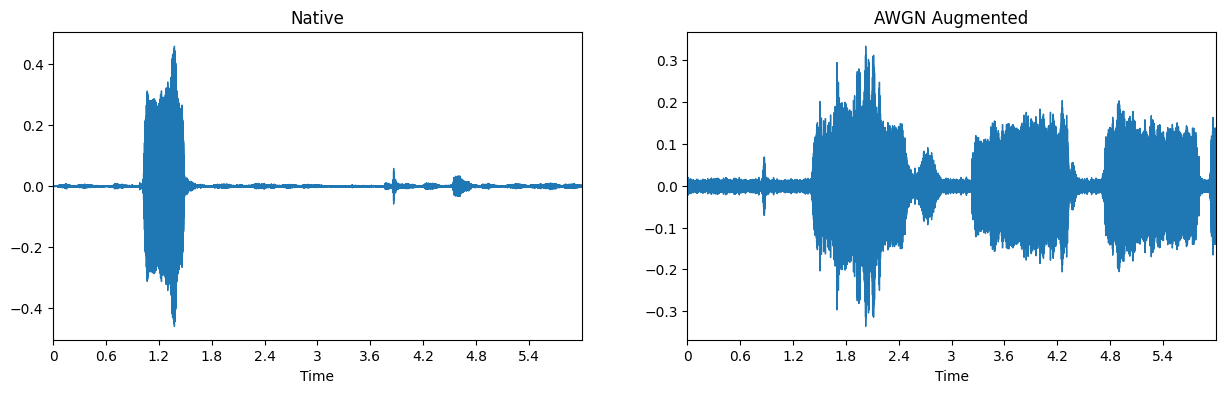

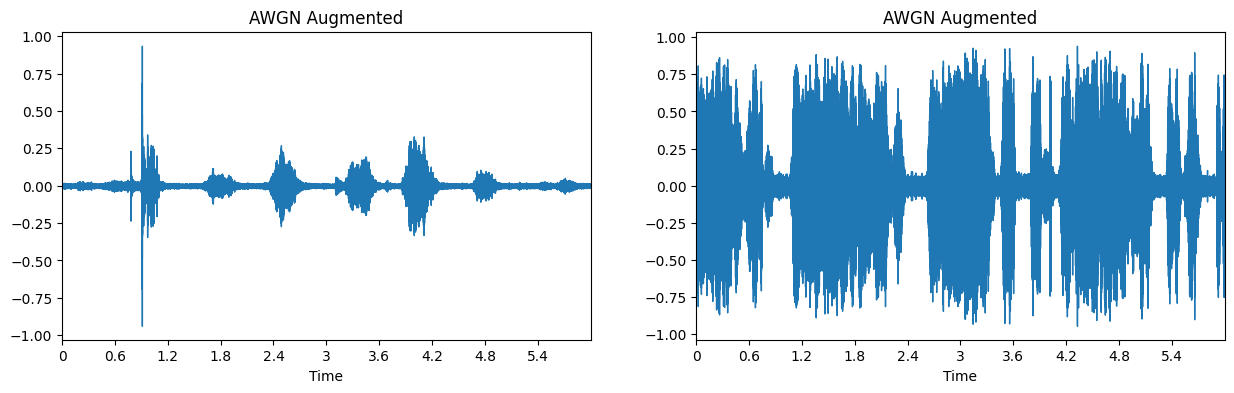

In [73]:
# pick a random waveform, but same one from native and augmented set for easier comparison
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(waveforms[12], sr=sample_rate)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveplot(augmented_waveforms_temp[0][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(augmented_waveforms_temp[2][0], sr=sample_rate)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveplot(augmented_waveforms_temp[7][0], sr=sample_rate)
plt.title('AWGN Augmented')
plt.show()

Looks noisy alright. Noise is clearly visible in otherwise-silent regions of the waveform. We can see the variability of the noise, which should have an SNR between 15 and 30.

**Note that augmentation was only done after splitting data into train, validation, and test sets - and we processed each set separately.**

**When we augmented the data before splitting it, test and validation data leaked into the training set giving a 97% test accuracy after training.**

## Format Data into Tensor Ready 4D Arrays
We don't have a colour channel in our MFCC feature array of dim (#samples, #MFC coefficients, time steps). **We have an analog of a black and white image: instead of 3 colour channels, we have 1 signal intensity channel: magnitude of each of 40 mel frequency coefficients at time t.**

**We need an input channel dim to expand to output channels using CNN filters. We create a dummy channel dim to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.**

In [74]:
# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with 
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')
type(X_train)

Shape of 4D feature array for input tensor: (1815, 1, 128, 188) train, (230, 1, 128, 188) validation, (240, 1, 128, 188) test
Shape of emotion labels: (1815,) train, (230,) validation, (240,) test


numpy.ndarray

In [75]:
del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

## Feature Scaling
Scaling will drastically decrease the length of time the model needs to train to convergence - it will have easier computations to perform on smaller magnitudes. **For reference, scaling reduces the time to convergence from about 100 to 50 epochs for this model.**

**Standard Scaling makes the most sense because we have features whose target distribution we don't know.** When I performed classification on this dataset with an MLP classifier standard scaling was best across a variety of conditions and features.

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#### Scale the training data ####
# store shape so we can transform it back 
N,C,H,W = X_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')
type(X_train)

X_train scaled:(1815, 1, 128, 188), y_train:(1815,)
X_valid scaled:(230, 1, 128, 188), y_valid:(230,)
X_test scaled:(240, 1, 128, 188), y_test:(240,)


numpy.ndarray

## Save and Reload Data as NumPy Arrays 
We can save the training/validation/test data as numpy arrays to enable faster loading in case the notebook kernel crashes / google colab runtime crashes / any number of reasons the training data might be cleared from memory. This is much faster than loading 457 files and computing their features again - not to mention augmented features.

In [77]:
###### SAVE #########
# choose save file name 
filename = 'features+labels.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to features+labels.npy


In [78]:
##### LOAD #########
# choose load file name 
filename = 'features+labels.npy'

# open file in read mode and read data 
with open(filename, 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}') 

X_train:(1815, 1, 128, 188), y_train:(1815,)
X_valid:(230, 1, 128, 188), y_valid:(230,)
X_test:(240, 1, 128, 188), y_test:(240,)


# Architecture Overview
As a whole, the CNN architecture of this network is inspired by a combination of the golden standards in image and sequence processing over the last few years.

Each 3-layer deep 2D convolutional block is extremely similar to the **classic [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture: Conv->Pool>Conv>Pool>FC.** 

**[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) forms the basis for increasing the complexity of feature maps with channel expansion through stacked CNN layers; [Inception and GoogLeNet](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf) are the inspiration for parallelizing CNN layers in the hopes of diverisfying the features learned by the network.** 

**[VGGNet](https://arxiv.org/pdf/1409.1556.pdf) proved the unreasonable efficiency of using fixed sized kernels throughout deeply stacked CNN layers;** I found this to extend to this task. Specifically, VGG saw an improvement over AlexNet largely by replacing large kernels (i.e. 11x11 stride 5) with smaller ones of 3x3 stride 1. One of the motivations that VGG cites for this is that the 3x3 kernel is the smallest kernel size choice in understanding spatial data w.r.t. up/down/left/right (although VGG also uses 1x1 kernels). VGGNet also inspires the maxpool kernel size of 2x2 stride 2, as I have used at the first layer of each convolutional block. 

We employ a model that combines parallel 2D
convolutional blocks with a transformer block for parallel 
transformer implantations. 
 The architecture starts with a transformer block that has 
many transformer encoder layers as well as a max-pooling 
layer to downsample the input feature map. Self-attention 
and feed-forward networks are used by these levels to 
process the information. Four layers of the transformer 
encoder are layered. 
 Two parallel 2D convolutional blocks follow. Three 
consecutive convolutional layers, batch normalization, 
ReLU activation, max pooling, and dropout are all included 
in each block. These blocks provide a flattened 1D array as 
their output. 
 The outputs from the transformer block and the 
convolutional blocks are then combined. A linear layer, 
followed by a SoftMax layer, which generates both logits 
(for loss computation) and SoftMax probabilities (for class 
prediction), is applied to the concatenated features. 
 The parallel convolutional and transformer blocks are 
traversed in a forward pass by the model using a tensor as 
an input. The output logits and SoftMax probabilities are 
returned. The constructor specifies the number of emotions 
as a parameter, and the model contains trainable 
parameters. We employed the Transformer-Encoder layer 
as described in the "Attention is All You Need" paper to 
train the network. The objective was to forecast frequency 
distributions of various emotions, leveraging the overall 
pattern of Mel-Frequency Cepstral Coefficients (MFCCs) 
linked with each emotion

# Build Model Architecture and Define Forward Pass

In [79]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(nn.Module):      # base module
    # Define all layers present in the network
    def __init__(self, num_emotions):
        super().__init__()                # initializes internal module state.
        
        ################## TRANSFORMER BLOCK #####################
        # MAXPOOL THE INPUT FEATURE MAP/TENSOR TO THE TRANSFORMER
        # rectangular kernel worked better here for the rectangular input
        self.transformer_maxpool = nn.MaxPool2d(kernel_size = [1, 4], stride = [1, 4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All you need"
        # 4 multi-head self-attention layers earch with 40 -->512 --> 40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model = 128, # input features (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead = 4, # 4 self-attention layers in each multi-head self-attention
            dim_feedforward = 1280, # 2 layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout = 0.5,
            activation = 'relu' # ReLU: avoid saturation/time gradient/ reduce compute time
            
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers = 4)
        
        
        
        # ======================== 1ST PARALLEL 2D CONVOLUTION BLOCK ===========================
        
        # 3 sequential conv2D layers: (1,128,188) --> (16, 64, 94) -> (32, 16, 21) -> (64, 4, 5)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels = 1,  # input volume depth == input channel dim == 1
                out_channels = 16, # expand output feature map volume's depth to 16
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 2, stride = 2), #typical maxpool kernel size
            nn.Dropout(p = 0.4),
            
            # 2nd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels = 16,  
                out_channels = 32, # expand output feature map volume's depth to 32
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 4, stride = 4), # increase maxpool kernel size
            nn.Dropout(p = 0.4),
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels = 32,  
                out_channels = 64, # expand output feature map volume's depth to 32
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(64), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 4, stride = 4), # increase maxpool kernel size
            nn.Dropout(p = 0.4),
        )
        
        
        # ======================== 2ND PARALLEL 2D CONVOLUTION BLOCK ===========================
        
        # 3 sequential conv2D layers: ( 1, 40, 188) --> (16, 20, 94) -> (32, 5, 21) -> (64, 1, 5)
        self.conv2Dblock2 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels = 1,  # input volume depth == input channel dim == 1
                out_channels = 16, # expand output feature map volume's depth to 16
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 2, stride = 2), #typical maxpool kernel size
            nn.Dropout(p = 0.3),
            
            # 2nd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels = 16,  
                out_channels = 32, # expand output feature map volume's depth to 32
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(32), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 4, stride = 4), # increase maxpool kernel size
            nn.Dropout(p = 0.4),
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels = 32,  
                out_channels = 64, # expand output feature map volume's depth to 32
                kernel_size = 3, # 3*3 stride 1 kernel
                stride = 1,
                padding = 1
            ),
            
            nn.BatchNorm2d(64), # batch normalize the output feature map before activation
            nn.ReLU(),  # feature map --> activation map
            nn.MaxPool2d(kernel_size = 4, stride = 4), # increase maxpool kernel size
            nn.Dropout(p = 0.4),
        )
        
        
        # ====================== FINAL LINEAR BLOCK ==========================
        # Linear softmax layer to take final concatenated embedding tensor
        #   from parallel 2D cnn and transformer block, output  output 8 logits 
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 8 output emotions 
        
        self.fc1_linear = nn.Linear(1280 * 2 + 128, num_emotions)
        
        # SOFTMAX layer for the 8 output logits from final FC linear layer
        self.softmax_out = nn.Softmax(dim = 1) # dim == 1 is frequency embedding
        
    
    # define one complete parallel fwd pass of input features tensor through 2*conv+1*transformer blocks
    
    def forward(self, x):
        
        # =========== 1st parallel Conc2D block: 3 con layers =================
        # create final feature embedding from 1st con layer
        # input features passed through 3 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x = features (x_train - N*C*B*H)
        
        # flatten final 64*1*8 feature map from con layer to length 512 1D array
        # skip the 1sst (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim = 1)
        
        
        # =========== 2nd parallel Conc2D block: 3 con layers =================
        # create final feature embedding from 1st con layer
        # input features passed through 3 sequential 2D convolutional layers
        conv2d_embedding2 = self.conv2Dblock2(x) # x = features (x_train - N*C*B*H)
        
        # flatten final 64*1*8 feature map from con layer to length 512 1D array
        # skip the 1sst (N/batch) dimension when flattening
        conv2d_embedding2 = torch.flatten(conv2d_embedding2, start_dim = 1)
        
        
        # ============ 4-encoder-layer Transformer block =================
        
        # maxpool input feature map: 1*40*94 w/ 1*4 kernel  --> 1*40*23
        x_maxpool = self.transformer_maxpool(x)
        
        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool, 1)   # squeeze removes single dimension entries
        
        # convert maxpooled feature map format: batch * freq * time --> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2, 0, 1)
        
        # finally, pass reduced input feature map 'x' into transformer encoder
        transformer_output = self.transformer_encoder(x)
        
        ## create final feature embedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim = 0) 
        
        
        # ============ concatenate frequency embeddings form con and transformer block ===============
        # concatenate tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1, conv2d_embedding2, transformer_embedding], dim = 1)
        
        
        # ============ final FC linear layer, need logits for loss =================
        output_logits = self.fc1_linear(complete_embedding)
        
        # ============ final softmax layer: use logits from FC linear, get softmax for prediction ==========
        output_softmax = self.softmax_out(output_logits)
        
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax          
    
print(emotion_num)

4


In [80]:
from torchinfo import summary

# instantiate model 
model = parallel_all_you_want(5)

# summary(model, input_size=(1, 40, 259))
# ValueError: expected 4D input (got 3D input)

summary(model, input_size=(1, 1, 128, 188))

Layer (type:depth-idx)                        Output Shape              Param #
parallel_all_you_want                         [1, 5]                    --
├─Sequential: 1-1                             [1, 64, 4, 5]             --
│    └─Conv2d: 2-1                            [1, 16, 128, 188]         160
│    └─BatchNorm2d: 2-2                       [1, 16, 128, 188]         32
│    └─ReLU: 2-3                              [1, 16, 128, 188]         --
│    └─MaxPool2d: 2-4                         [1, 16, 64, 94]           --
│    └─Dropout: 2-5                           [1, 16, 64, 94]           --
│    └─Conv2d: 2-6                            [1, 32, 64, 94]           4,640
│    └─BatchNorm2d: 2-7                       [1, 32, 64, 94]           64
│    └─ReLU: 2-8                              [1, 32, 64, 94]           --
│    └─MaxPool2d: 2-9                         [1, 32, 16, 23]           --
│    └─Dropout: 2-10                          [1, 32, 16, 23]           --
│    └─Conv2d: 2

## Define Loss/Criterion

We must define the loss function (criterion per PyTorch notation) for the backwards pass of each training iteration. Since our classes our balanced we don't need to specify a class-weight parameter (to balance classes).

**PyTorch nn.CrossEntropyLoss() implements log softmax and negative log likelihood loss (nn.NLLoss() --> nn.LogSoftmax())
We use log softmax for computation benefits and faster gradient optimization. Log softmax heavily penalizes the model when failing to predict the correct class.**

In [81]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

## Choose Optimizer

I used Adam to train an MLP due to its faster compute and convergence. Adam is great and usually works well with defaults.

**However, a lot of 2018-2020 papers still use SGD. It seems to me that the reason is SGD with properly tuned momentum sometimes (often) converges to lower loss with enough training.**

**Quoting [Wilson et al, 2017](https://arxiv.org/abs/1705.08292):** 

    “We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even 
    when these solutions have better training performance. These results suggest that practitioners should reconsider the 
    use of adaptive methods to train neural networks."


"Adaptive methods" refers to the likes of Adam.
   
**I took full advantage of plain old SGD by using the highest momentum leading to convergence, plus a generously long training time.**

In [82]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001, weight_decay=1e-3, momentum=0.8)

## Define Training Step

We define a function to return a single training step defining one iteration of our model.

    Forward pass output logits and softmax probabilities. 

    Record the softmax probabilities to track accuracy. 

    Pass output logits to loss function to compute loss.
    
    Call backwards pass with loss function (backpropogate errors).
    
    Tell optimizer to apply one update step to network parameters.
    
    Zero the accumulated gradient in the optimizer for next iteration.


In [83]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

## Define Validation Step

Define a function to return a single validation step on the 10% X,y tensor pair to get an idea of our model's generalizibiliy as it trains so we know whether and when to stop it and tune hyperparameters. **Make sure we _do not_ update network parameters during validation by setting model to validation mode. Do not waste resources computing gradients in validation phase by setting torch.no_grad().**

In [84]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

# Make Checkpoint Functions
It's a good idea to save checkpoints of the model state after each epoch. We'll then interrupt training when satisfied with the model's performance and load the appropriate model binary. 

- Resume training if hardware/software fails
- Save compute re-training by training from checkpoint after tuning
- Implement early stopping easily by keeping snapshot of most performant version of model
- Google Colab throttles GPU usage eventually; can't keep re-training from scratch indefinitely

In [85]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [86]:
print(X_train.shape[0])
print(y_train.shape[0])


1815
1815


# Build Training Loop

Build the complete training loop using the training and validation step functions. 

This model is not reasonable to train on CPU, but it's a good way to check if the model compiled successfully. I'm using RTX 2060 6 GB. This model is pretty big (1,643,077 params to learn if I've checked the math correctly) but trains to convergence within ~10 minutes on a K80.

Pick the number of epochs (complete pass of all training samples) to use that is higher than reasonable so the model does not terminate just before convergence - I manually stopped it when it converges. 

**Minibatch size:** [From Yann LeCun's twitter](https://twitter.com/ylecun/status/989610208497360896?lang=en) (with LeCun facebook comment appended) [citing this 2018 minibatch paper](https://arxiv.org/abs/1804.07612):


    
    "Training with large minibatches is bad for your health. More importantly, it's bad for your test error. Friends dont 
    let friends use minibatches larger than 32. Let's face it: the only people have switched to minibatch sizes larger than one since 2012 is because GPUs are inefficient for batch sizes smaller than 32. That's a terrible reason. It just means our hardware sucks." 
    


<br>
That's about it for the logic. Here's the full training loop:

    --Setup--
    
    Instantiate model.

    Instantiate training and validation steps with model, loss function, and optimizer. 
    
    Move model to GPU.
    
        --Epoch--
    
        Set model to train mode after each post-epoch validation phase completes.
    
        Shuffle the training set for each  epoch, reset epoch loss and accuracy. 
        
            --Iteration--
    
            Create X_train, y_train minibatch tensors for each iteration and move tensors to GPU.
            
            Take 1 train step with X_train, y_train minibatch tensors.

            Aggregate accuracy and loss from each iteration, but only record after each epoch. 
            
        --Epoch--

        Compute and record validation accuracy for the entire epoch to keep track of learning progress. 

        Print training metrics after each epoch.

In [89]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=len(emotions_dict)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
        # Save checkpoint of the model
        checkpoint_filename = 'D:\InfantCryClassifier\checkpoints\parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')


cuda selected
Number of trainable params:  1643077


### Train Model

In [90]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 50

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 55/56
Epoch 0 --- loss:6.361, Epoch accuracy:72.56%, Validation loss:1.746, Validation accuracy:82.61%
Epoch 1: iteration 55/56
Epoch 1 --- loss:1.212, Epoch accuracy:75.87%, Validation loss:1.282, Validation accuracy:82.61%
Epoch 2: iteration 55/56
Epoch 2 --- loss:0.988, Epoch accuracy:77.52%, Validation loss:1.172, Validation accuracy:82.61%
Epoch 3: iteration 55/56
Epoch 3 --- loss:0.785, Epoch accuracy:78.51%, Validation loss:1.137, Validation accuracy:67.83%
Epoch 4: iteration 55/56
Epoch 4 --- loss:0.719, Epoch accuracy:81.82%, Validation loss:0.951, Validation accuracy:79.57%
Epoch 5: iteration 55/56
Epoch 5 --- loss:0.723, Epoch accuracy:80.06%, Validation loss:1.140, Validation accuracy:83.04%
Epoch 6: iteration 55/56
Epoch 6 --- loss:0.621, Epoch accuracy:82.04%, Validation loss:1.126, Validation accuracy:82.61%
Epoch 7: iteration 55/56
Epoch 7 --- loss:0.556, Epoch accuracy:84.08%, Validation loss:1.346, Validation accuracy:69.57%
Epoch 8: iteration 55/56

# Check the Loss Curve's Behaviour
Let's see if we missed something egregious during training. Note that validation sets achieved 78-82% accuracy depending on the random split of data (checked after tuning; random seed was specified before splitting data while tuning the model).

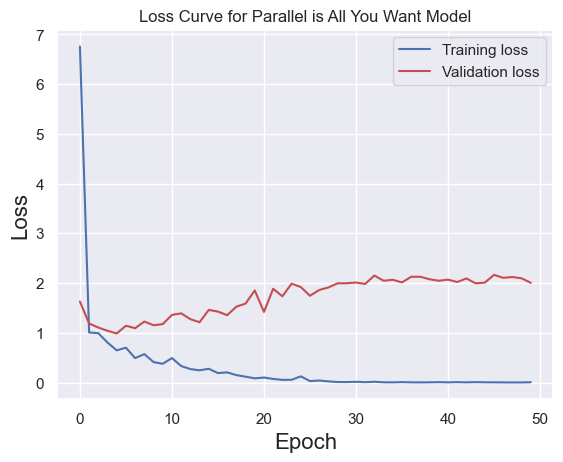

In [ ]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

# Load the Trained Model from Checkpoint for Evaluation

In [ ]:
load_folder = 'D:\InfantCryClassifier\checkpoints'  

# pick the epoch to load
epoch = '049'
model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = parallel_all_you_want(5)
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from D:\InfantCryClassifier\checkpoints\parallel_all_you_wantFINAL-049.pkl


# Evaluate the Model on Hold-Out Test Set
Fingers crossed for generalizability.

In [ ]:
# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test).float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long)

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

Test accuracy is 80.42%


# Analyze Performance on Test Set

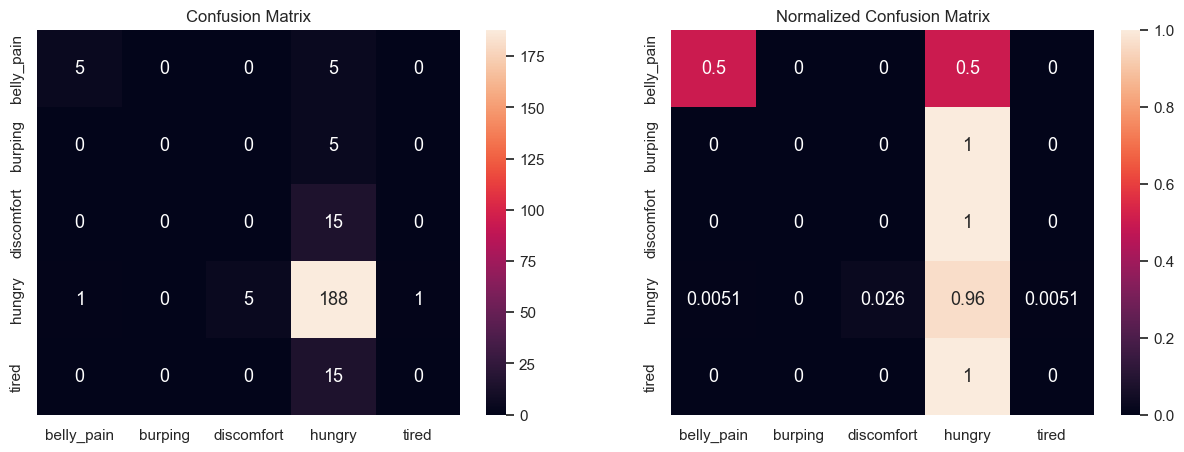

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions.cpu().numpy()
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in emotions_dict.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(15,5))
sn.set(font_scale=1.0) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13},fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()